In [23]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

#from main import evaluate
from lipreading.utils import load_json, calculateNorm2, load_model
from lipreading.dataloaders import get_preprocessing_pipelines
from lipreading.dataset import MyDataset, pad_packed_collate
from lipreading.model import Lipreading

def get_model_from_json(config_path, modality, num_classes, extract_feats=False, use_boundary=False):
    assert config_path.endswith('.json') and os.path.isfile(config_path), \
        f"'.json' config path does not exist. Path input: {config_path}"
    args_loaded = load_json( config_path)
    backbone_type = args_loaded['backbone_type']
    width_mult = args_loaded['width_mult']
    relu_type = args_loaded['relu_type']
    #use_boundary = args_loaded.get("use_boundary", False)

    if args_loaded.get('tcn_num_layers', ''):
        tcn_options = { 'num_layers': args_loaded['tcn_num_layers'],
                        'kernel_size': args_loaded['tcn_kernel_size'],
                        'dropout': args_loaded['tcn_dropout'],
                        'dwpw': args_loaded['tcn_dwpw'],
                        'width_mult': args_loaded['tcn_width_mult'],
                      }
    else:
        tcn_options = {}
    if args_loaded.get('densetcn_block_config', ''):
        densetcn_options = {'block_config': args_loaded['densetcn_block_config'],
                            'growth_rate_set': args_loaded['densetcn_growth_rate_set'],
                            'reduced_size': args_loaded['densetcn_reduced_size'],
                            'kernel_size_set': args_loaded['densetcn_kernel_size_set'],
                            'dilation_size_set': args_loaded['densetcn_dilation_size_set'],
                            'squeeze_excitation': args_loaded['densetcn_se'],
                            'dropout': args_loaded['densetcn_dropout'],
                            }
    else:
        densetcn_options = {}

    model = Lipreading( modality=modality,
                        num_classes=num_classes,
                        tcn_options=tcn_options,
                        densetcn_options=densetcn_options,
                        backbone_type=backbone_type,
                        relu_type=relu_type,
                        width_mult=width_mult,
                        use_boundary=use_boundary,
                        extract_feats=extract_feats).cuda()
    calculateNorm2(model)
    return model

def evaluate(model, label_list, dset_loader, criterion, num_show = 30, use_boundary=False):

    model.eval()

    running_loss = 0.
    running_corrects = 0.
    final_preds = []
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(dset_loader)):
            if use_boundary:
                input, lengths, labels, boundaries = data
                boundaries = boundaries.cuda()
            else:
                input, lengths, labels = data
                boundaries = None
            #print(labels)
            logits = model(input.unsqueeze(1).cuda(), lengths=lengths, boundaries=boundaries)
            _, preds = torch.max(F.softmax(logits, dim=1).data, dim=1)
            running_corrects += preds.eq(labels.cuda().view_as(preds)).sum().item()

            # plot the input image 
            for i in range(input.size(0)):
                for j in range(input.size(1)):
                    plt.subplot(1, input.size(1), j+1)
                    plt.suptitle("label: " + label_list[labels[i]] + " predict: " + str(label_list[preds[i].item()]))
                    plt.axis('off')
                    plt.imshow(input[i][j], cmap="gray", )
                if num_show:
                    num_show -= 1
                    plt.show()


            loss = criterion(logits, labels.cuda())
            running_loss += loss.item() * input.size(0)

    
    print(f"{len(dset_loader.dataset)} in total\tCR: {running_corrects/len(dset_loader.dataset)}")
    return running_corrects/len(dset_loader.dataset), running_loss/len(dset_loader.dataset)

def get_data_loaders(test = True, modality='video', data_dir='train_visual_data/', label_path='label/labels.txt', 
                     annonation_direc='train_annotation', batch_size=32, workers=1, use_boundary=False):
    preprocessing = get_preprocessing_pipelines(modality)

    # create dataset object for each partition
    partitions = ['test'] if test else ['train', 'val', 'test']
    dsets = {partition: MyDataset(
                modality=modality,
                data_partition=partition,
                data_dir=data_dir,
                label_fp=label_path,
                annonation_direc=annonation_direc,
                preprocessing_func=preprocessing[partition],
                data_suffix='.npz',
                use_boundary=use_boundary,
                ) for partition in partitions}
    dset_loaders = {x: torch.utils.data.DataLoader(
                        dsets[x],
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn=pad_packed_collate,
                        pin_memory=True,
                        num_workers=workers,
                        worker_init_fn=np.random.seed(1)) for x in partitions}
    return dset_loaders

# MS-TCN

2-norm of the neural network: 46.2189
Partition test loaded


  0%|          | 0/182 [00:00<?, ?it/s]

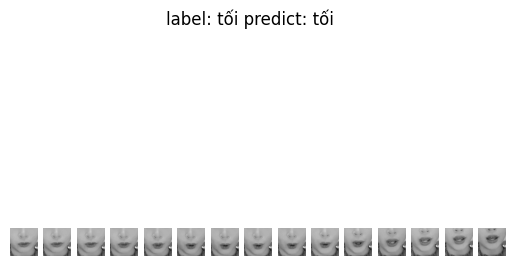

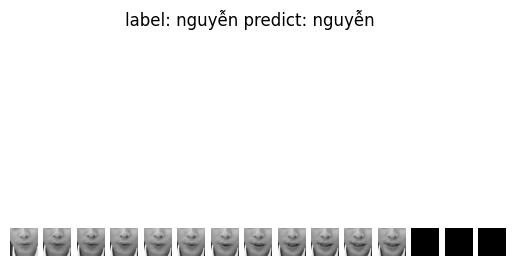

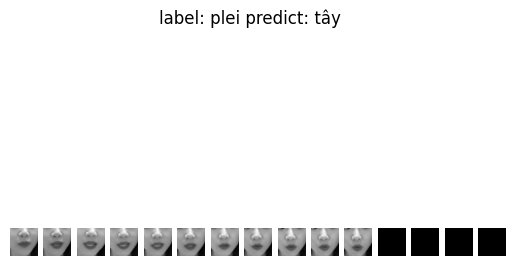

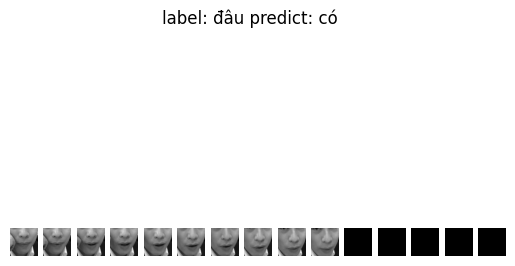

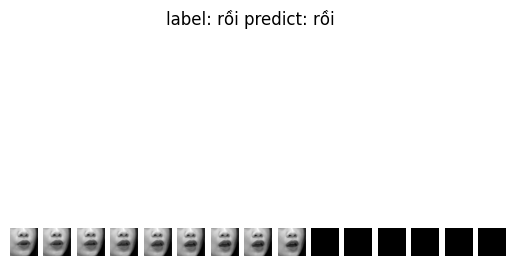

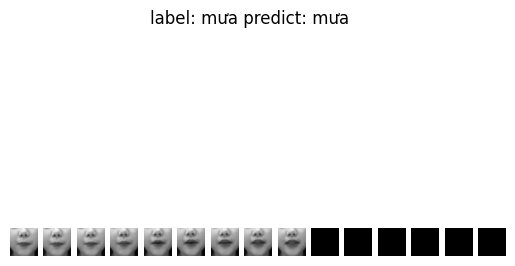

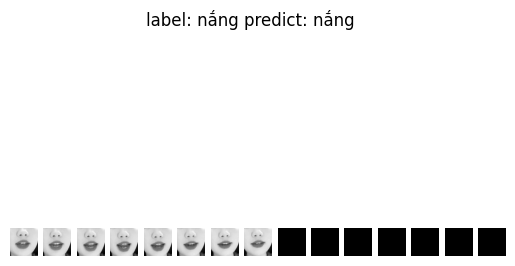

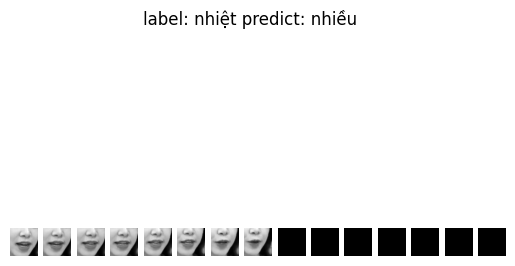

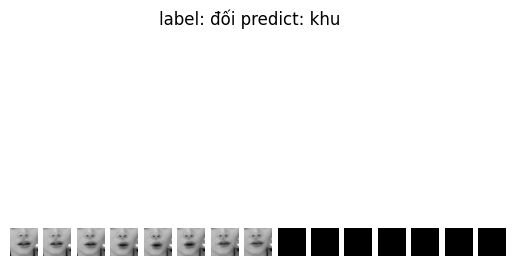

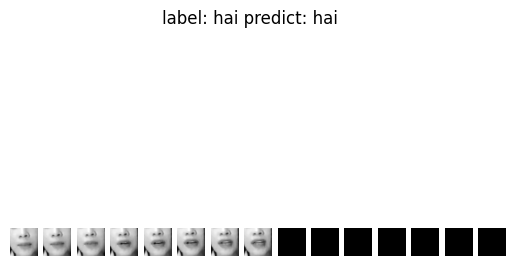

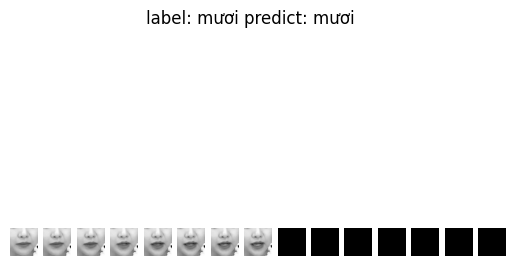

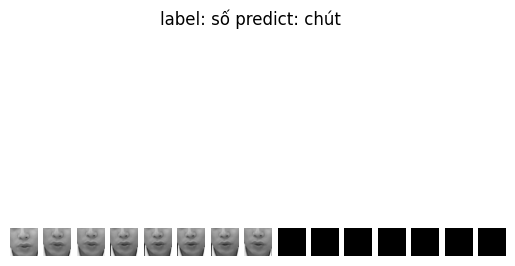

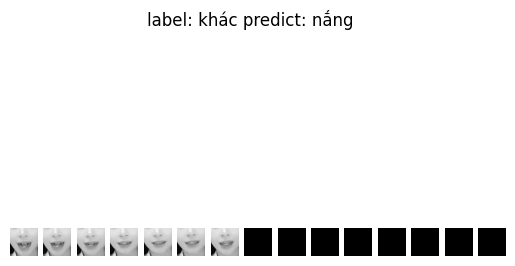

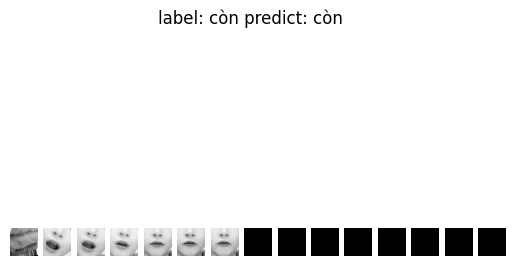

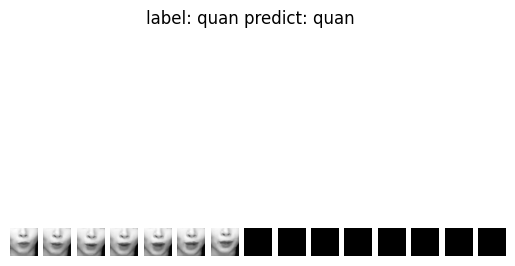

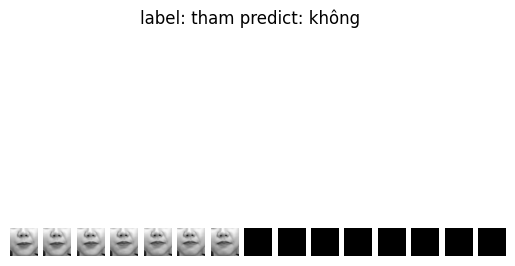

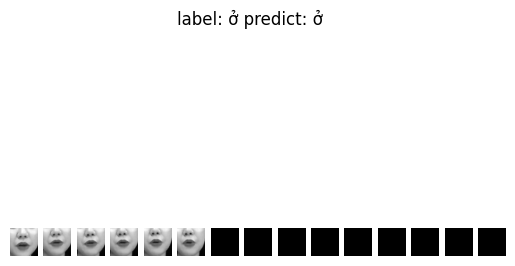

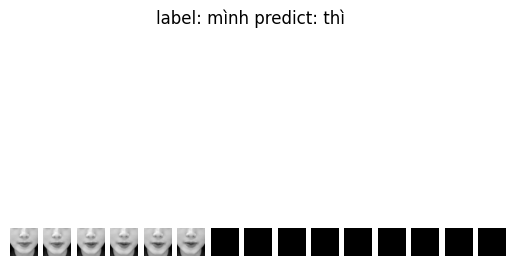

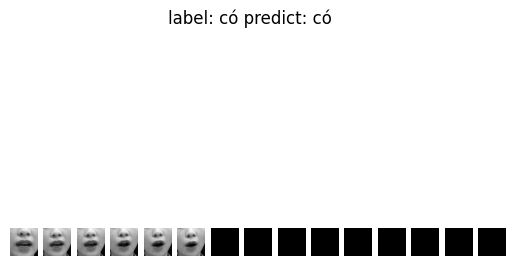

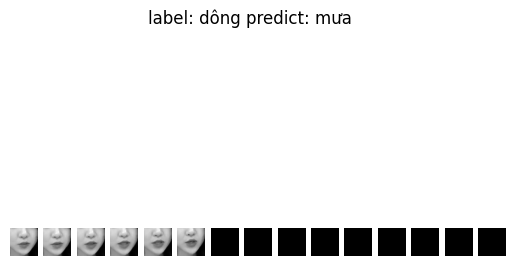

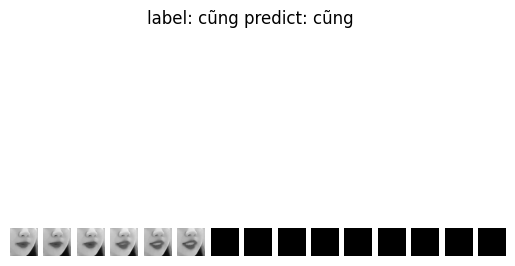

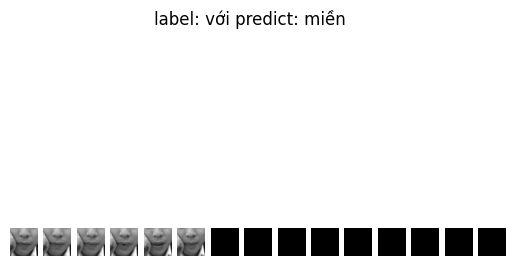

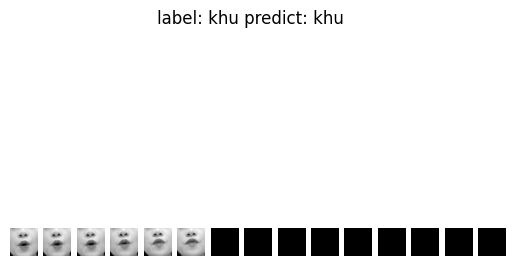

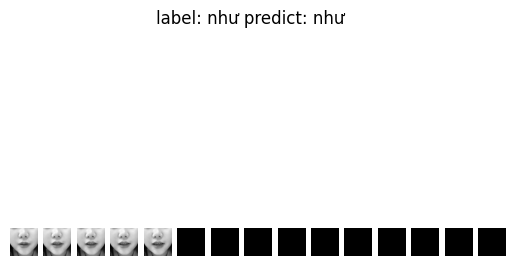

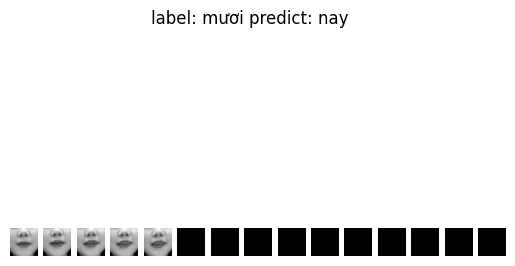

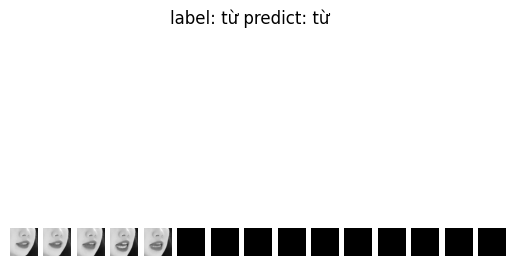

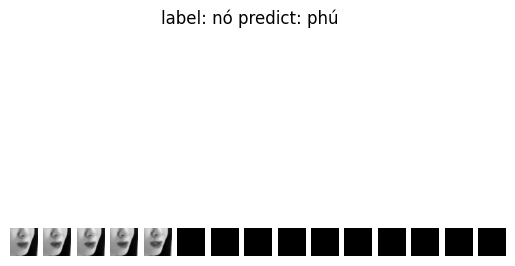

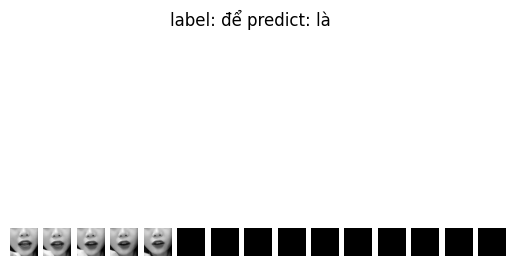

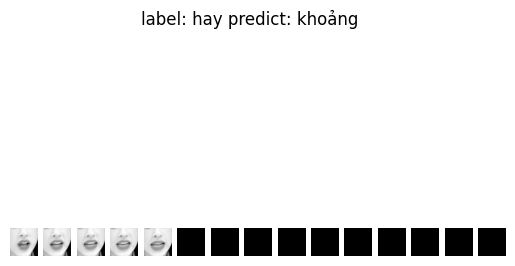

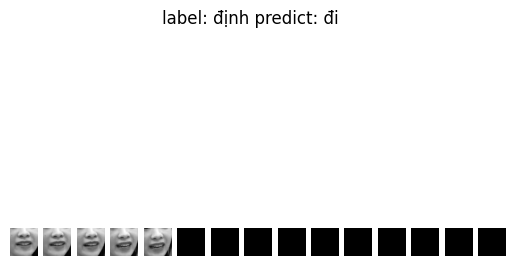

  1%|          | 1/182 [00:06<19:09,  6.35s/it]/tmp/ipykernel_10455/4184105148.py:81: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, input.size(1), j+1)
100%|██████████| 182/182 [01:35<00:00,  1.90it/s]


5811 in total	CR: 0.4777146790569609


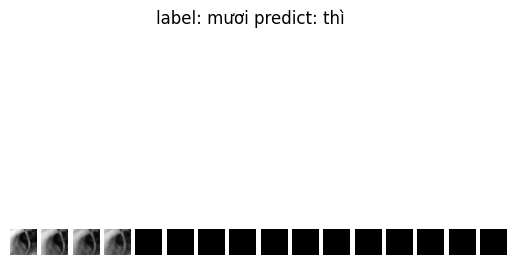

In [28]:
if "__main__" == __name__:
    # -- config
    config_path = "configs/lrw_resnet18_mstcn.json"
    modality = "video"
    num_classes = 624
    model = get_model_from_json(config_path, modality, num_classes)
    # -- load model
    model_path = "train_logs/new_data_mst-tcn/2023-03-08T09:54:04/ckpt.best.pth"
    model = load_model(model_path, model)
    #-- evaluate
    label_list = [line.strip() for line in open('labels/labels.txt')]
    criterion = nn.CrossEntropyLoss()
    dset_loaders = get_data_loaders(test=True, modality=modality, data_dir='train_visual_data', label_path='labels/labels.txt')
    acc_avg_test, loss_avg_test = evaluate(model, label_list, dset_loaders['test'], criterion)

# DC-TCN

2-norm of the neural network: 81.9193
Partition test loaded


  0%|          | 0/182 [00:00<?, ?it/s]

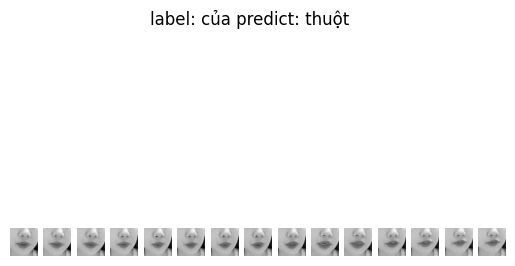

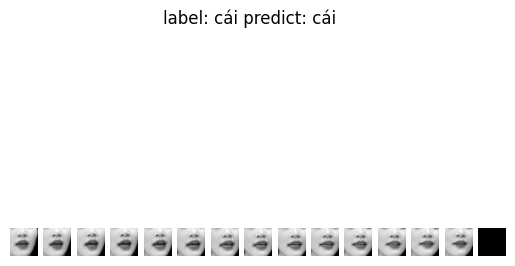

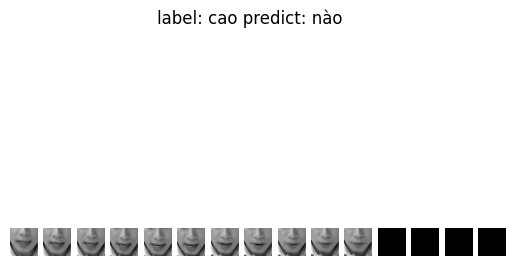

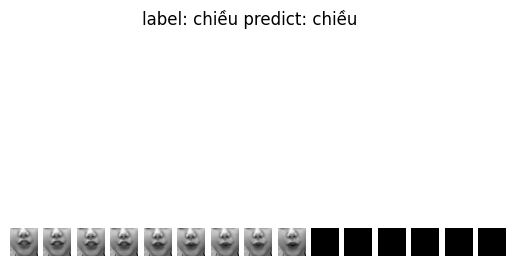

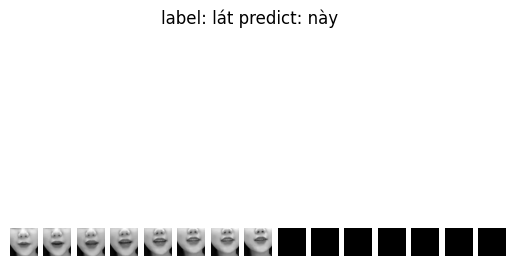

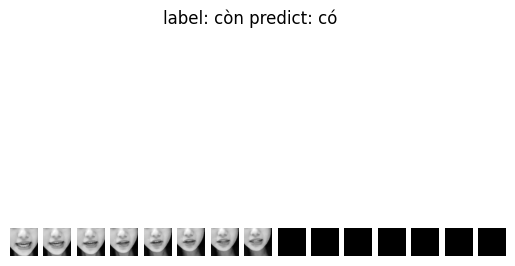

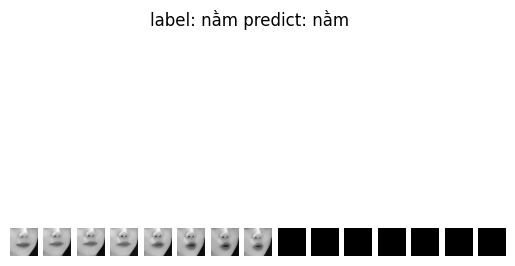

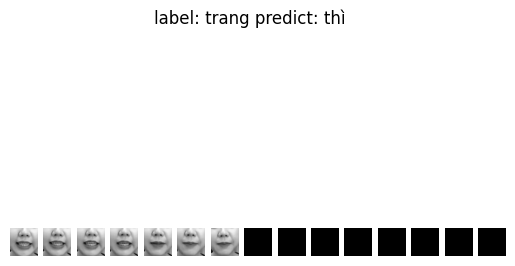

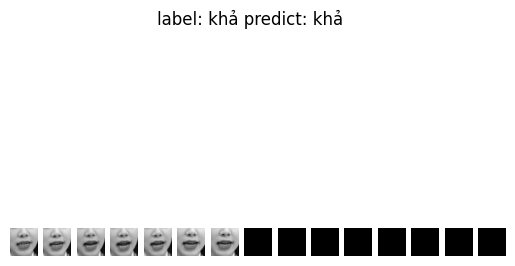

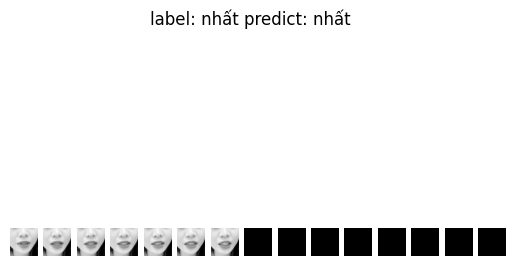

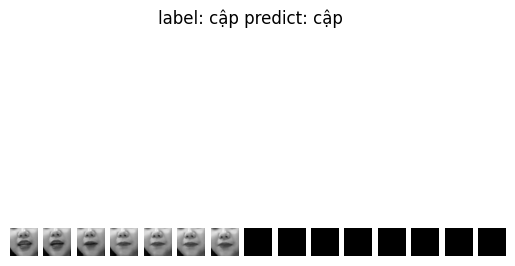

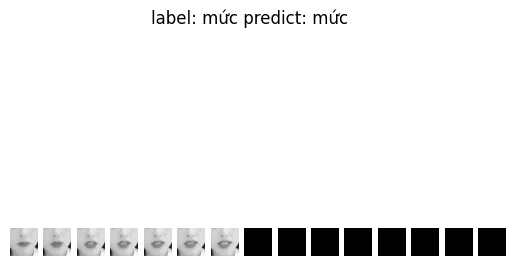

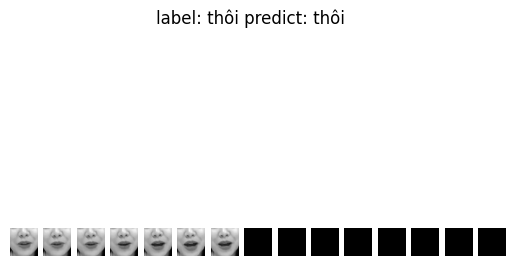

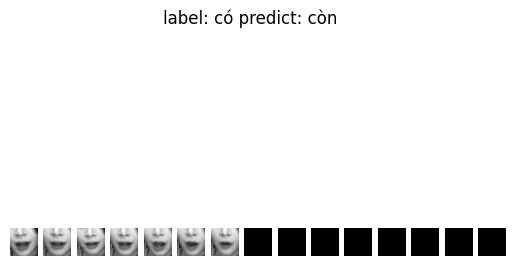

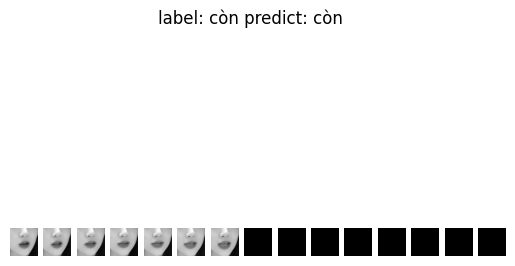

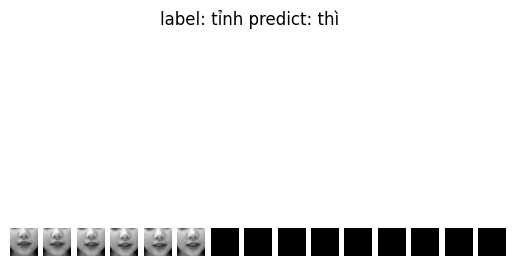

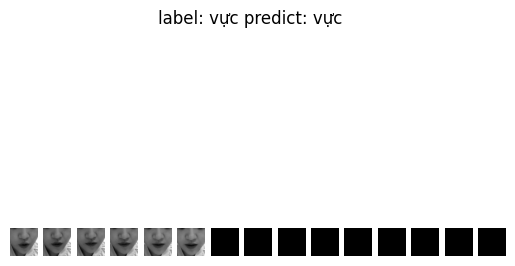

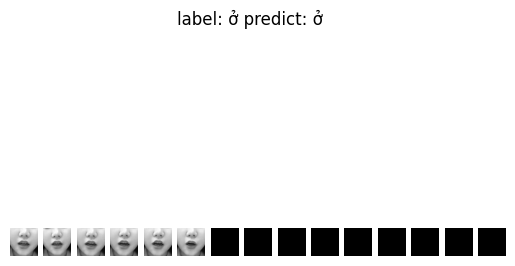

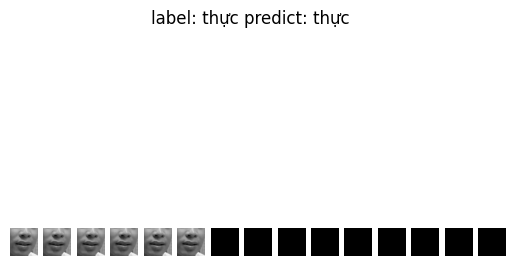

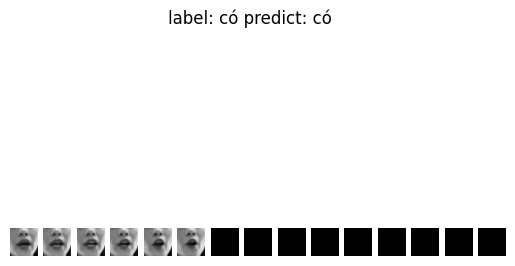

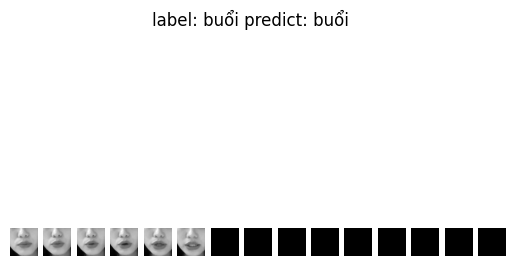

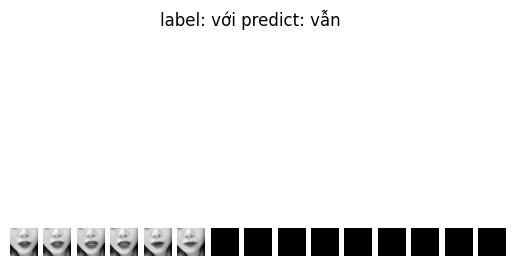

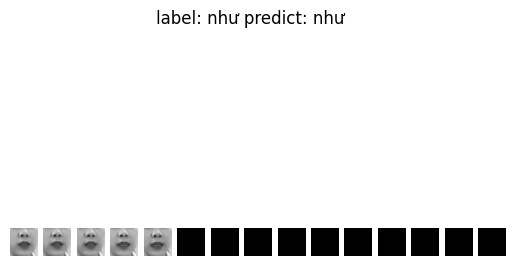

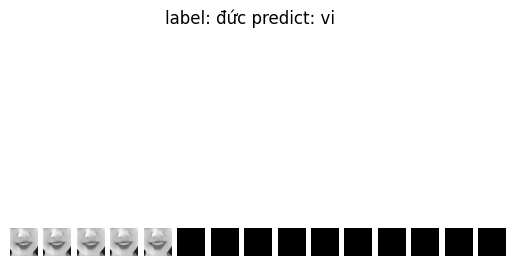

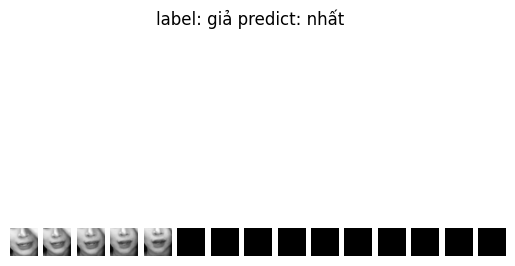

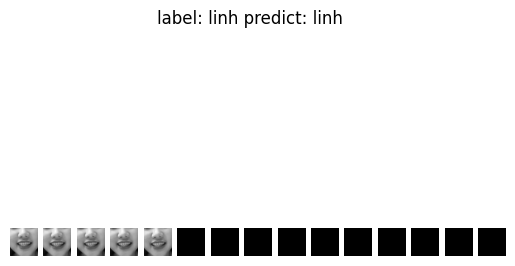

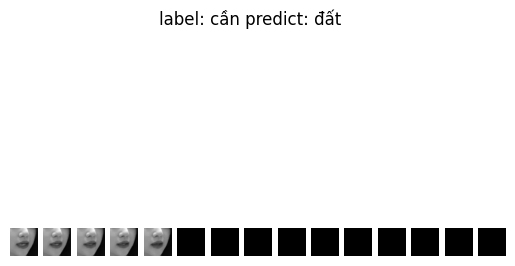

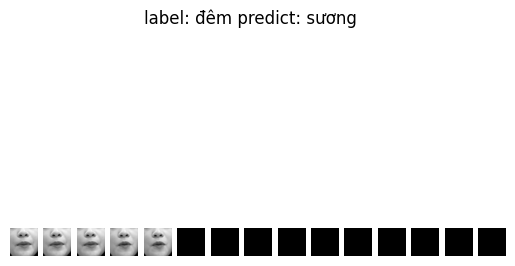

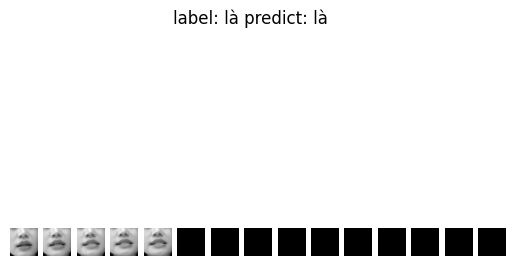

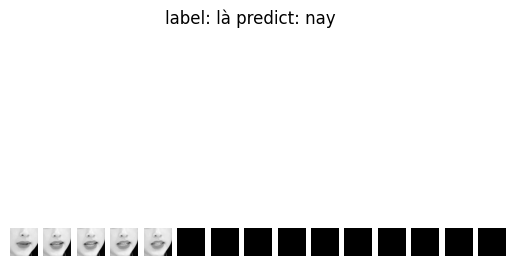

  1%|          | 1/182 [00:06<18:28,  6.13s/it]/tmp/ipykernel_10455/4184105148.py:81: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, input.size(1), j+1)
100%|██████████| 182/182 [01:39<00:00,  1.83it/s]


5811 in total	CR: 0.5394940629839958


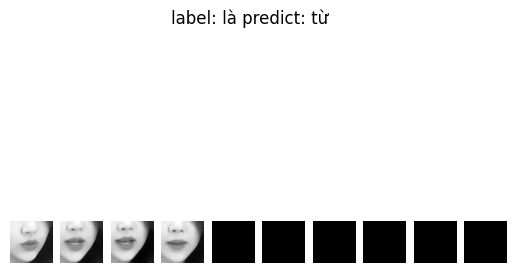

In [29]:
if "__main__" == __name__:
    # -- config
    config_path = "configs/lrw_resnet18_dctcn.json"
    modality = "video"
    num_classes = 624
    model = get_model_from_json(config_path, modality, num_classes)
    # -- load model
    model_path = "train_logs/dctcn_boundary/2023-03-14T13:52:29/ckpt.best.pth"
    model = load_model(model_path, model)
    #-- evaluate
    label_list = [line.strip() for line in open('labels/labels.txt')]
    criterion = nn.CrossEntropyLoss()
    dset_loaders = get_data_loaders(test=True, modality=modality, data_dir='train_visual_data', label_path='labels/labels.txt')
    acc_avg_test, loss_avg_test = evaluate(model, label_list, dset_loaders['test'], criterion)